<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EC%96%91%EB%B0%A9%ED%96%A5_LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.xls to data (1).xls


In [ ]:
xlsx = pd.read_excel(r'data.xls')

In [ ]:
xlsx.head()

,년/월/일,종가,대비,거래량(주),거래대금(원),시가,고가,저가,시가총액(백만),상장주식수(주)
0,2020/09/02,"54,400",200,"16,905,723","922,056,312,614","54,600","55,100","54,100","324,756,171","5,969,782,550"
1,2020/09/01,"54,200",200,"19,363,117","1,052,420,037,800","54,100","54,800","54,100","323,562,214","5,969,782,550"
2,2020/08/31,"54,000","-1,400","32,671,367","1,786,245,513,500","56,000","56,100","54,000","322,368,258","5,969,782,550"
3,2020/08/28,"55,400",-200,"14,619,888","815,588,008,400","56,100","56,300","55,400","330,725,953","5,969,782,550"
4,2020/08/27,"55,600",-800,"16,196,568","903,860,902,050","56,300","56,300","55,600","331,919,910","5,969,782,550"


In [ ]:
xlsx = xlsx.rename(columns={"년/월/일" : "day", "종가":"close", "대비":"dif", "거래량(주)":"volume", "시가":"start", "고가":"high", "저가":"low"})

In [ ]:
xlsx.tail()

,day,close,dif,volume,거래대금(원),start,high,low,시가총액(백만),상장주식수(주)
81,2020/05/11,"48,400",-400,"16,357,743","797,523,862,042","48,900","49,250","48,300","288,937,475","5,969,782,550"
82,2020/05/08,"48,800",0,"15,319,700","752,271,196,120","49,100","49,350","48,800","291,325,388","5,969,782,550"
83,2020/05/07,"48,800",-400,"13,884,411","679,668,516,460","49,200","49,300","48,700","291,325,388","5,969,782,550"
84,2020/05/06,"49,200",700,"18,070,225","882,453,648,920","49,000","49,200","48,500","293,713,301","5,969,782,550"
85,2020/05/04,"48,500","-1,500","26,083,749","1,270,816,552,521","48,900","49,100","48,500","289,534,454","5,969,782,550"


In [ ]:
del xlsx["거래대금(원)"]
del xlsx["시가총액(백만)"]
del xlsx["상장주식수(주)"]

In [ ]:
sprice_s = xlsx[::-1]  # 여기부터 다시

In [ ]:
sprice_s = sprice_s.reset_index()  #reset_index() 함수를 사용하여 dataframe의 순서를 완전히 바꾼다 

In [ ]:
sprice_s.head()

,index,day,close,dif,volume,start,high,low
0,85,2020/05/04,"48,500","-1,500","26,083,749","48,900","49,100","48,500"
1,84,2020/05/06,"49,200",700,"18,070,225","49,000","49,200","48,500"
2,83,2020/05/07,"48,800",-400,"13,884,411","49,200","49,300","48,700"
3,82,2020/05/08,"48,800",0,"15,319,700","49,100","49,350","48,800"
4,81,2020/05/11,"48,400",-400,"16,357,743","48,900","49,250","48,300"


In [2]:
import numpy as np

In [ ]:
for i in range(0, len(sprice_s)):
  sprice_s.loc[i, 'close'] = float(sprice_s.loc[i, 'close'].replace(",", ''))
  sprice_s.loc[i, 'dif'] = float(sprice_s.loc[i, 'dif'].replace(",", ''))
  sprice_s.loc[i, 'volume'] = float(sprice_s.loc[i, 'volume'].replace(",", ''))
  sprice_s.loc[i, 'start'] = float(sprice_s.loc[i, 'start'].replace(",", ''))
  sprice_s.loc[i, 'high'] = float(sprice_s.loc[i, 'high'].replace(",", ''))
  sprice_s.loc[i, 'low'] = float(sprice_s.loc[i, 'low'].replace(",", ''))
 

In [ ]:
sprice_s.head()

,index,day,close,dif,volume,start,high,low
0,85,2020/05/04,48500,-1500,2.60837e+07,48900,49100,48500
1,84,2020/05/06,49200,700,1.80702e+07,49000,49200,48500
2,83,2020/05/07,48800,-400,1.38844e+07,49200,49300,48700
3,82,2020/05/08,48800,0,1.53197e+07,49100,49350,48800
4,81,2020/05/11,48400,-400,1.63577e+07,48900,49250,48300


In [ ]:
# 거래량 지표인 obv를 계산한다. 전일 종가보다 금일 종가가 높다면 전일 obv에 금일 거래량을 더해주고, 전일 종가보다 금일 종가가 낮다면 거래량을 전일 obv에서 차감한다.
# obv가 증가한다는 것은 매수 세력이 이겼다는 것(주가상승)을 의미하고 obv가 하락하면 매도세력(주가하락)이 이긴 것을 의미한다.
# obv는 주가변화에 선행한다. 그러나 변화가 발생하는 경우가 있다.
# 주가는 상승추세지만 obv가 횡보라면 공매도 신호로 이후 주가 하락 신호
# 반대로 주가는 횡보이지만 obs가 상승세라면 이후 주가 상승 신호 

obv=0

obvs=[]

for i in range(len(sprice_s)):
  if i == 0 :
    obv = 0
  elif sprice_s.loc[i, 'close'] - sprice_s.loc[i-1, 'close'] > 0 :
    obv = obv + sprice_s.loc[i, 'volume']
  else:
    obv = obv - sprice_s.loc[i, 'volume']
  obvs.append(obv)

In [ ]:
for i in range(len(sprice_s)):
  sprice_s.loc[i,'obv'] = obvs[i]

In [ ]:
sprice_s.head()

,index,day,close,dif,volume,start,high,low,obv
0,85,2020/05/04,48500,-1500,2.60837e+07,48900,49100,48500,0.0
1,84,2020/05/06,49200,700,1.80702e+07,49000,49200,48500,18070225.0
2,83,2020/05/07,48800,-400,1.38844e+07,49200,49300,48700,4185814.0
3,82,2020/05/08,48800,0,1.53197e+07,49100,49350,48800,-11133886.0
4,81,2020/05/11,48400,-400,1.63577e+07,48900,49250,48300,-27491629.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scale_cols = ['close', 'dif', 'volume', 'start', 'high', 'low', 'obv']
sprice_s = scaler.fit_transform(sprice_s[scale_cols])

In [ ]:
sprice_s = pd.DataFrame(sprice_s) 

In [ ]:
sprice_s.columns = scale_cols

In [ ]:
sprice_s[0:1]

,close,dif,volume,start,high,low,obv
0,0.058296,0.163636,0.408246,0.126437,0.081301,0.110169,0.22903


In [ ]:
print(scaler.inverse_transform(sprice_s[0:1])) # scale값을 역으로 변환한다.

[[ 4.8500000e+04 -1.5000000e+03  2.6083749e+07  4.8900000e+04
   4.9100000e+04  4.8500000e+04  0.0000000e+00]]


In [ ]:
sprice_s.to_csv('new_file.txt')
files.download('new_file.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving new_file (9).txt to new_file (9).txt


In [4]:
data = pd.read_csv('new_file (9).txt')

In [5]:
data

,Unnamed: 0,close,dif,volume,start,high,low,obv
0,0,0.058296,0.163636,0.408246,0.126437,0.081301,0.110169,0.229030
1,1,0.121076,0.563636,0.203619,0.134100,0.089431,0.110169,0.286215
2,2,0.085202,0.363636,0.096733,0.149425,0.097561,0.127119,0.242276
3,3,0.085202,0.436364,0.133384,0.141762,0.101626,0.135593,0.193796
4,4,0.049327,0.363636,0.159890,0.126437,0.093496,0.093220,0.142031
...,...,...,...,...,...,...,...,...
81,81,0.695067,0.290909,0.155775,0.693487,0.666667,0.711864,0.862660
82,82,0.677130,0.400000,0.115514,0.678161,0.666667,0.694915,0.816394
83,83,0.551570,0.181818,0.576462,0.670498,0.650407,0.576271,0.713004
84,84,0.569507,0.472727,0.236633,0.524904,0.544715,0.584746,0.774280


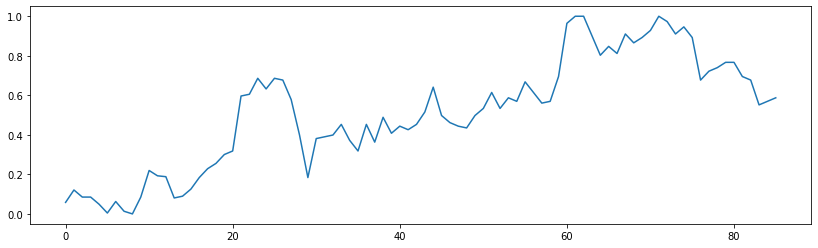

In [6]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(data['close'])
plt.show()

In [7]:
y_data = data.loc[0:85, 'close']  # y는 종가의 차이로 전날에 영향을 받는다고 가정한다

In [8]:
y_data = np.array(y_data)

In [9]:
x_data = data.loc[0:85, ['close', 'obv']]

In [10]:
x_data.head()

,close,obv
0,0.058296,0.229030
1,0.121076,0.286215
2,0.085202,0.242276
3,0.085202,0.193796
4,0.049327,0.142031


In [ ]:
# 여기부터 이상하다.

In [11]:
x_serise=[]
for i in range(len(y_data)-4):
  xz = [[x_data.loc[i, 'close'],x_data.loc[i, 'obv']], [x_data.loc[i+1, 'close'],x_data.loc[i+1, 'obv']], [x_data.loc[i+2, 'close'],x_data.loc[i+2, 'obv']],
       [x_data.loc[i+3, 'close'],x_data.loc[i+3, 'obv']], [x_data.loc[i+4, 'close'],x_data.loc[i+4, 'obv']]]
  x_serise.append(xz)

In [12]:
x_serise[0]

[[0.05829596412556004, 0.22903013989475876],
 [0.12107623318385576, 0.2862146468584997],
 [0.08520179372197312, 0.2422764447875824],
 [0.08520179372197312, 0.1937961690116901],
 [0.049327354260089606, 0.14203093263557506]]

In [14]:
y = y_data[5:]
x = x_serise[:81]
print(len(y), len(x))

81 81


In [15]:
x = np.array(x)

In [17]:
x = x.reshape(81,5,2)
y = y.reshape(81,1)

In [18]:
x[0]

array([[0.05829596, 0.22903014],
       [0.12107623, 0.28621465],
       [0.08520179, 0.24227644],
       [0.08520179, 0.19379617],
       [0.04932735, 0.14203093]])

In [19]:
y = np.array(y)
x_train = x[0:70]
x_val = x[70:]
y_train = y[0:70]
y_val = y[70:]

In [20]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)


import tensorflow as tf

import numpy as np

from tensorflow import keras
import keras.layers as layers
from keras.layers import Dense, LSTM,Input, Bidirectional,Concatenate
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K 

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [21]:
def policy_model_lstm (lr):
  inp_L = layers.Input(shape=(5,2))  # 타입스텝수 5개, 특성개수 1개
  dense_1 = Bidirectional(LSTM(5),merge_mode = 'concat')(inp_L)
  dense_2 = Dense(128)(dense_1) 
  dense_L = Dense(64)(dense_2) 
  output_s = layers.Dense(1)(dense_L)

  model_train = Model(inputs=inp_L, outputs = output_s)
  model_train.compile(loss='mse', optimizer=Adam(lr), metrics = ['mae'])
  return model_train

In [22]:
model_train_test = policy_model_lstm(0.01)

In [23]:
model_train_test.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 2)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10)                320       
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_test = model_train_test.fit(x_train, y_train, validation_data = (x_val, y_val ),  epochs=100, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


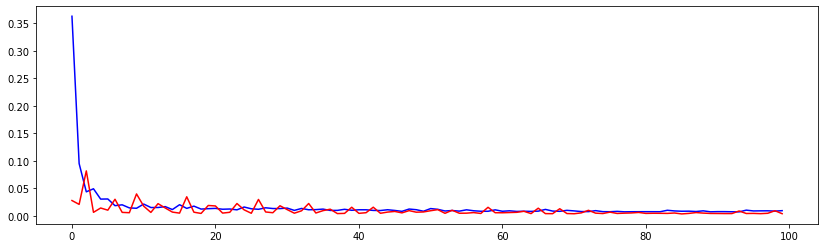

In [25]:
plt.plot(history_test.history['loss'], 'b') 
plt.plot(history_test.history['val_loss'], 'r')
plt.show()

In [26]:
y_hat = model_train_test.predict(x_val)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


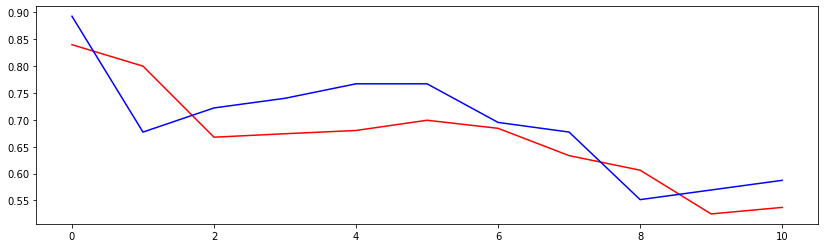

In [27]:
plt.plot(y_hat, 'r') 
plt.plot(y_val, 'b')
plt.show()

Attention Model, 새로운 시도

In [ ]:
inp_L = layers.Input(shape=(5,1)) 
lstm = Bidirectional(LSTM(5,return_sequences = True))(inp_L)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(5,return_sequences=True, return_state=True))(lstm)

순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 5, 10) (None, 5) (None, 5) (None, 5) (None, 5)


양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 됩니다.

In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
print(state_h.shape, state_c.shape)

(None, 10) (None, 10)


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # 여기서 value는 lstm 값이고, query는 state (은익상태)값이다.
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    # expand_dim은 차원을 하나 추가해준다. 예를 들면 [0,1,2] --> [[0], [1], [2]]
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(5) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
output = Dense(1, activation="sigmoid")(dense1)
model = Model(inputs=inp_L, outputs=output)

In [ ]:
model.compile(loss='mse', optimizer=Adam(0.01), metrics = ['mae'])

In [ ]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val ),  epochs=200, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


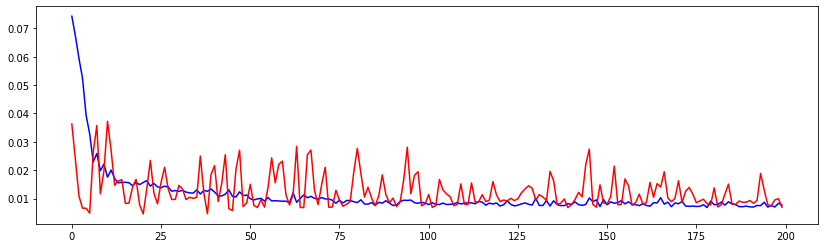

In [ ]:
plt.plot(history.history['loss'], 'b') 
plt.plot(history.history['val_loss'], 'r')
plt.show()

In [ ]:
y_hat = model.predict(x_val)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


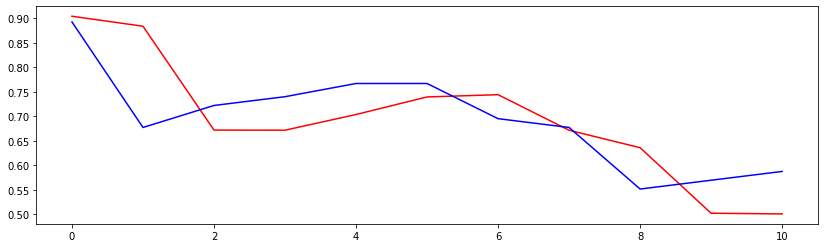

In [ ]:
plt.plot(y_hat, 'r') 
plt.plot(y_val, 'b')
plt.show()